### Basic Concepts: Nodes, Edges & State

In [1]:
from typing import TypedDict
from langgraph.graph import END, START, StateGraph


class InputState(TypedDict):
    string_value: str
    numeric_value: int


def modify_state(input: InputState):
    print(f"Current value: {input}")
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge(START, "branch_a")
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [2]:
from typing import TypedDict
from pydantic import BaseModel
from langgraph.graph import START, END, StateGraph

class state (TypedDict):
    string_value: str
    numeric_value: int

class state_pydantic(BaseModel):
    string_value: str
    numeric_value: int

In [28]:
def modify (input: state):
    input["string_value"] = input["string_value"].upper()
    input["numeric_value"] += 1

    return input

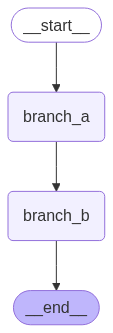

In [25]:
# def modify (input: state):
#     print(f"Current value: {input}")
#     return input

graph = StateGraph (state)

graph.add_node ("branch_a", modify)
graph.add_node ("branch_b", modify)

graph.add_edge (START, "branch_a")
graph.add_edge ("branch_a", "branch_b")
graph.add_edge ("branch_b", END)

graph.add_edge (START, "branch_a")

run = graph.compile()

run

In [27]:
run.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'A', 'numeric_value': 3}

In [22]:
run.invoke({"string_value": "a", "numeric_value": 1})

Current value: {'string_value': 'a', 'numeric_value': 1}
Current value: {'string_value': 'a', 'numeric_value': 1}


{'string_value': 'a', 'numeric_value': 1}

In [43]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 1
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)


graph.set_entry_point("branch_a")

runnable = graph.compile()

In [17]:
try:
    runnable.invoke({"string_value": "a"})
except KeyError as e:
    print(e)

ValidationError: 1 validation error for state_pydantic
numeric_value
  Field required [type=missing, input_value={'string_value': 'a'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing

In [30]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'aaa', 'numeric_value': 3}

### Why not use just LCEL?

In [31]:
from langchain_core.runnables import RunnableLambda

In [33]:
runnable = RunnableLambda(modify_state)

chain = runnable | runnable
chain

RunnableLambda(modify_state)
| RunnableLambda(modify_state)

In [34]:
chain.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'aaa', 'numeric_value': 3}

In [37]:
runnable = RunnableLambda(modify_state)
runnable1 = RunnableLambda(modify)

chain = runnable | runnable1
chain.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'AA', 'numeric_value': 3}

### Cycles and Conditional Edges

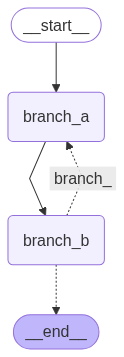

In [56]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 2
    print ( f" modify_state: Current value: {input}")
    return input

def modify_brach_b(input: InputState):
    input["string_value"] += "b"
    input["numeric_value"] -= 1
    print(f" modify: Current value: {input}")
    return input

def router(input: InputState):
    if input["numeric_value"] < 8:
        return "branch_"
    else:
        return "__end__"


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_brach_b)
graph.add_edge("branch_a", "branch_b")
graph.add_conditional_edges(
    "branch_b", router, {"branch_": "branch_a", "__end__": END}
)

graph.set_entry_point("branch_a")

runnable = graph.compile()
runnable

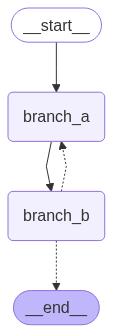

In [34]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [57]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

 modify_state: Current value: {'string_value': 'aa', 'numeric_value': 3}
 modify: Current value: {'string_value': 'aab', 'numeric_value': 2}
 modify_state: Current value: {'string_value': 'aaba', 'numeric_value': 4}
 modify: Current value: {'string_value': 'aabab', 'numeric_value': 3}
 modify_state: Current value: {'string_value': 'aababa', 'numeric_value': 5}
 modify: Current value: {'string_value': 'aababab', 'numeric_value': 4}
 modify_state: Current value: {'string_value': 'aabababa', 'numeric_value': 6}
 modify: Current value: {'string_value': 'aabababab', 'numeric_value': 5}
 modify_state: Current value: {'string_value': 'aababababa', 'numeric_value': 7}
 modify: Current value: {'string_value': 'aababababab', 'numeric_value': 6}
 modify_state: Current value: {'string_value': 'aabababababa', 'numeric_value': 8}
 modify: Current value: {'string_value': 'aabababababab', 'numeric_value': 7}
 modify_state: Current value: {'string_value': 'aababababababa', 'numeric_value': 9}
 modify: 

{'string_value': 'aababababababab', 'numeric_value': 8}

### Reducer functions

In [36]:
from typing import TypedDict, Annotated
from langgraph.graph import END, StateGraph
from operator import add


class InputState(TypedDict):
    no_change_value: str
    string_value: Annotated[str, add]
    numeric_value: Annotated[int, add]
    list_value: Annotated[list[str], add]


def modify_state(input: InputState):
    return input

In [37]:
graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [38]:
runnable.invoke(
    {
        "no_change_value": "a",
        "string_value": "a",
        "numeric_value": 1,
        "list_value": ["a"],
    }
)

{'no_change_value': 'a',
 'string_value': 'aaaa',
 'numeric_value': 4,
 'list_value': ['a', 'a', 'a', 'a']}

### Alternative State

In [39]:
from typing import TypedDict
from langgraph.graph import END, StateGraph


class InputState(TypedDict):
    string_value: str
    numeric_value: int


# class InputState(BaseModel):
#       string_value: str
#       numeric_value: int


def modify_state(input: InputState):
    string_value = input["string_value"]
    # string_value = input.string_value
    print(string_value)
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [40]:
runnable.invoke({"string_value": "a", "numeric_value": "a"})

a
a


{'string_value': 'a', 'numeric_value': 'a'}